# Import and misc

In [1]:
!pip install torchaudio==0.9.1

     |████████████████████████████████| 1.9 MB 5.3 MB/s 
     |████████████████████████████████| 831.4 MB 7.1 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.


In [1]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

In [2]:
seed_ = 808
torch.manual_seed(seed_)
torch.cuda.manual_seed(seed_)
np.random.seed(seed_)
torch.backends.cudnn.deterministic = True

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [3]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [4]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2021-11-22 18:11:27--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.69.128, 2607:f8b0:4001:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.69.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   225MB/s    in 6.1s    

2021-11-22 18:11:33 (233 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [5]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [6]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [7]:
dataset.csv.sample(5)

,path,keyword,label
63903,speech_commands/marvin/876c84d6_nohash_0.wav,marvin,0
62346,speech_commands/sheila/30aabd44_nohash_0.wav,sheila,1
5203,speech_commands/happy/d91a159e_nohash_0.wav,happy,0
27299,speech_commands/five/363c6bad_nohash_0.wav,five,0
11231,speech_commands/stop/ad63d93c_nohash_0.wav,stop,0


### Augmentations

In [8]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [9]:
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [10]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

In [ ]:
# train_df.to_csv('train', index=False)
# val_df.to_csv('val', index=False)

In [11]:
#lets fix all data for our future work, so you should simply download the data(not to use different splits all the time)

train_df = pd.read_csv('train')
val_df = pd.read_csv('val')
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [12]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [13]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [14]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [15]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [16]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [17]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

## LET's add some functions for memory/macs/etc estimation



In [18]:
#memory
def get_size_in_megabytes(model):
    num_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
    param_size = next(model.parameters()).element_size()
    return (num_params * param_size) / (2 ** 20)

In [19]:
!pip install thop

In [20]:
from thop import profile

#macs
def get_macs(model):
    return profile(model, (torch.rand(1, TaskConfig.n_mels, 300), ))

#combine all info
def model_info(model):
    model_sz = get_size_in_megabytes(model)
    macs, params = get_macs(model)
    print(f'Model size {model_sz} MB, model macs {macs}, model parametrs count {params}')

### Quality measurment functions:

In [21]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [22]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [67]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [24]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [25]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [26]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [68]:
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [28]:
sum([p.numel() for p in model.parameters()])

70443

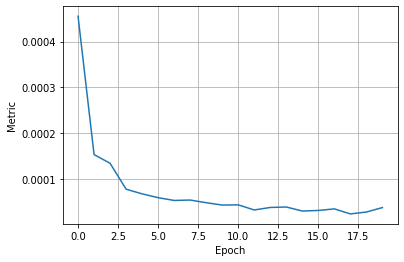

END OF EPOCH 19


In [ ]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
# torch.save(model.state_dict(), "base_model.pt")

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.0004554193612008855,
              0.00015329436226385482,
              0.00013426982057523876,
              7.770343705378597e-05,
              6.752280088039229e-05,
              5.916823426682188e-05,
              5.3087303281658856e-05,
              5.3988402966408226e-05,
              4.8187946717557916e-05,
              4.302601805988763e-05,
              4.3509389413958476e-05,
              3.230233505661189e-05,
              3.781038147398723e-05,
              3.8806961920034566e-05,
              2.9980959047555538e-05,
              3.127591687265895e-05,
              3.468338654147945e-05,
              2.3697131444634362e-05,
              2.7796836632864986e-05,
              3.757167957074237e-05]})

In [69]:
config = TaskConfig()
model = CRNN(config)
model.load_state_dict(torch.load('base_model.pt'))

<All keys matched successfully>

In [31]:
model_info(model)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
Model size 0.2687187194824219 MB, model macs 3055808.0, model parametrs count 70443.0


In [ ]:
validation(model.to(config.device), val_loader, melspec_val, config.device)

102it [00:07, 13.31it/s]


3.757167957074237e-05

In [30]:
#so here we have our results for our BASE model
#lets make dictionary for all results
RESULTS = dict()
RESULTS['base_model'] = {'macs': 3055808, 'model_sz': 0.2687187194824219, 'file_sz': 278.51, 'params': 70443, 'metric': 3.76e-5}

### Reproduce

In [ ]:
history = defaultdict(list)
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


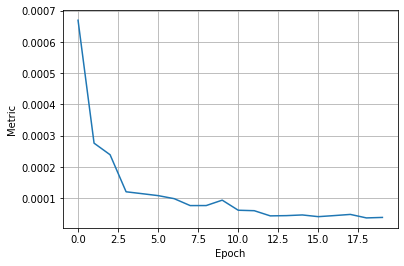

END OF EPOCH 19


In [ ]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.000668929262332049,
              0.00027623777753012457,
              0.000239244950074751,
              0.00012088461135078273,
              0.00011483351810352531,
              0.00010863323616673985,
              9.895387399016041e-05,
              7.682024001177994e-05,
              7.689185058275341e-05,
              9.416790083010079e-05,
              6.19491114396246e-05,
              6.048109473466867e-05,
              4.3927117744637006e-05,
              4.470886647776394e-05,
              4.689895644003562e-05,
              4.1432682855728125e-05,
              4.487595781003536e-05,
              4.859373995307418e-05,
              3.7416523333633206e-05,
              3.898002079988709e-05]})

### Streaming

In [41]:
#let's take 4 random words and one sheila of course(we put it in the middle)
paths = ['speech_commands/left/f852895b_nohash_1.wav',
         'speech_commands/off/2fa39636_nohash_1.wav',
         'speech_commands/sheila/51eefcc6_nohash_0.wav',
         'speech_commands/one/ec5ab5d5_nohash_2.wav',
         'speech_commands/no/97f493b9_nohash_1.wav']

In [42]:
#concatenate all our audios(words)
audios = torch.tensor([])
for p in paths:
    audio,  _ = torchaudio.load(p)
    audios = torch.cat((audios, audio), dim=-1)

In [95]:
#here our streaming model
class StreamingModel(nn.Module):
    def __init__(self, model, config, max_window_length):
        super().__init__()
        self.config = config
        self.model = model
        self.max_length = max_window_length

    @torch.no_grad()
    def fwd(self, x, hidden):

        self.memory = torch.cat((self.memory, x), dim=2)[:, :, -self.max_length:]

        #one step for streaming model
        inp = self.memory.unsqueeze(dim=1)
        conv_ = self.model.conv(inp).transpose(-1, -2)
        output, hidden = self.model.gru(conv_, hidden)
        contex_vector = self.model.attention(output)
        logits = self.model.classifier(contex_vector)

        probs = F.softmax(logits, dim=-1)

        return probs.cpu(), hidden
    

    @torch.no_grad()
    def reset_memory(self, x):
        sz = [1, self.config.n_mels, self.max_length]
        if x.dim() != 2:
          sz[0] = x.size(0)
        self.memory = torch.zeros(tuple(sz)).to(self.config.device)

In [96]:
#here we create base model and then create a streaming one
config = TaskConfig()
model = CRNN(config)
model.load_state_dict(torch.load('base_model.pt'))
streaming_model = StreamingModel(model, config, max_window_length=40)
streaming_model = streaming_model.to(config.device)

Text(0, 0.5, 'Probability')

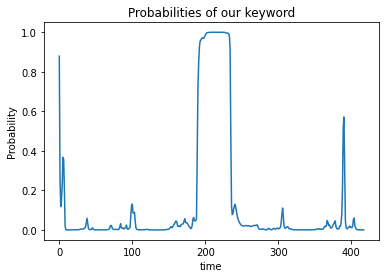

In [111]:
streaming_model.eval()

melspec = LogMelspec(is_train=False, config=config)
spec = melspec(audios.to(config.device))
streaming_model.reset_memory(spec)

hidden = None
results = []

streaming_step_size = 1
max_window_length = 40

for i in range(max_window_length, spec.shape[2] + 1, streaming_step_size):
    tmp = spec[:, :, i - max_window_length:i]
    if hidden is not None:
        hidden.to(config.device)
    outs, hidden = streaming_model.fwd(tmp.to(config.device), hidden)
    results.append(outs[0][1]) 

plt.plot(results)
plt.title("Probabilities of our keyword")
plt.xlabel("time")
plt.ylabel("Probability")

### DK Distillation


In [112]:
def train_epoch_with_teacher(model, teacher, opt, loader, log_melspec, device, T=20):
        model.train()
        for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
            batch, labels = batch.to(device), labels.to(device)
            batch = log_melspec(batch).to(device)

            opt.zero_grad()

            # run model # with autocast():
            logits_main = model(batch)
            logits_teacher = teacher(batch)
            # we need probabilities so we use softmax & CE separately
            probs_main = F.softmax(logits_main, dim=-1)
            probs_teacher = F.softmax(logits_teacher / T, dim=-1)

            #losses
            loss_main = F.cross_entropy(logits_main, labels)
            loss_teacher = -(probs_main * probs_teacher).sum(dim=-1).mean()
            loss_main += loss_teacher


            loss_main.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

            opt.step()

            # logging
            argmax_probs = torch.argmax(probs_main, dim=-1)
            FA, FR = count_FA_FR(argmax_probs, labels)
            acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

        return acc

#but we don't need to change anything in validation!

In [113]:
#simply decrease hidden size by 2 times
#channels also by 2 times

@dataclasses.dataclass
class DKD_TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 4
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 32
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

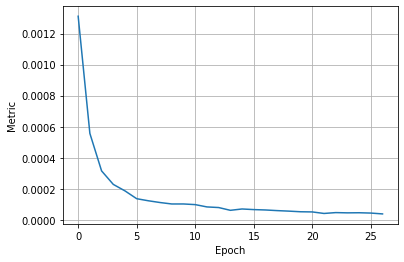

END OF EPOCH 27
metric: 3.809085621029996e-05


In [ ]:
history = defaultdict(list)
#so we want our new model to be better than base_model_score * 1.1 (or we can even put 1.05)
GOOD_QUALITY = RESULTS['base_model']['metric'] * 1.075

config = DKD_TaskConfig()
model = CRNN(config).to(config.device)
teacher_config = TaskConfig()
teacher = CRNN(teacher_config).to(config.device)
teacher.load_state_dict(torch.load('base_model.pt'))


opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

#train
# for n in range(TaskConfig.num_epochs):
n = 1
while len(history['val_metric']) == 0 or history['val_metric'][-1] >= GOOD_QUALITY:

    train_epoch_with_teacher(model, teacher, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)
    print('metric:', au_fa_fr)
    n += 1

In [ ]:
# torch.save(model.state_dict(), 'dkd_model.pt')

In [114]:
config = DKD_TaskConfig()
model = CRNN(config)
model.load_state_dict(torch.load('dkd_model.pt'))

<All keys matched successfully>

In [115]:
model_info(model.cpu())

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
Model size 0.06893539428710938 MB, model macs 910432.0, model parametrs count 18071.0


In [ ]:
validation(model.to(config.device), val_loader, melspec_val, config.device)

102it [00:07, 13.25it/s]


3.809085621029996e-05

In [116]:
RESULTS['dkd_model'] = {'macs': 910432, 'model_sz': 0.06893539428710938, 'file_sz': 73.95, 'params': 18071, 'metric': 3.81e-5}

Ага, уменьшили в 2 раза каналы и hidden_size, получили почти такое же качество(да, немного побольше эпох)
НО! 

### Quantization

In [117]:
def quant(conf, model_name):
    conf.device = 'cpu'
    tmp_model = CRNN(conf)
    tmp_model.load_state_dict(torch.load(model_name))

    q_model = torch.quantization.quantize_dynamic(
        tmp_model, 
        {nn.GRU, nn.Conv2d, nn.Linear},
        dtype=torch.qint8
    )

    cpu_melspec_val = LogMelspec(is_train=False, config=conf)

    res = validation(q_model, val_loader, cpu_melspec_val, device='cpu')
    print(res)

    torch.save(q_model.state_dict(), 'Q8_' + model_name)
    print(model_info(q_model))
    return res

In [ ]:
quant(TaskConfig(), 'base_model.pt')

102it [00:12,  8.33it/s]


3.711814595457712e-05
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.mod

3.711814595457712e-05

In [118]:
RESULTS['Q8_base_model'] = {'macs': 523584, 'model_sz': 0.003082275390625, 'file_sz': 80.78, 'params': 808, 'metric': 3.712e-5}

In [ ]:
quant(DKD_TaskConfig(), 'dkd_model.pt')

102it [00:11,  8.60it/s]


3.687944405133225e-05
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.mod

3.687944405133225e-05

In [119]:
RESULTS['Q8_dkd_model'] = {'macs': 261792, 'model_sz': 0.0015411376953125, 'file_sz': 27.22, 'params': 404, 'metric': 3.688e-5}

### Again DKD

In [120]:
#let's do something more
#decrease hidden size by 4 times
#channels also by 2 times

@dataclasses.dataclass
class DKD_m_TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 4
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 16
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

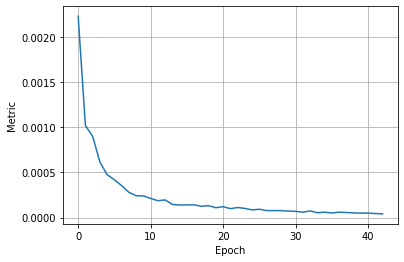

END OF EPOCH 43
metric: 4.026304352982827e-05


In [ ]:
history = defaultdict(list)
#so we want our new model to be better than base_model_score * 1.1 (or we can even put 1.05)
GOOD_QUALITY = RESULTS['base_model']['metric'] * 1.075

config = DKD_m_TaskConfig()
model = CRNN(config).to(config.device)
teacher_config = TaskConfig()
teacher = CRNN(teacher_config).to(config.device)
teacher.load_state_dict(torch.load('base_model.pt'))


opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

#train
# for n in range(TaskConfig.num_epochs):
n = 1
while len(history['val_metric']) == 0 or history['val_metric'][-1] >= GOOD_QUALITY:

    train_epoch_with_teacher(model, teacher, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)
    print('metric:', au_fa_fr)
    n += 1

In [ ]:
# torch.save(model.state_dict(), 'dkd_m_model.pt')

In [121]:
config = DKD_m_TaskConfig()
model = CRNN(config)
model.load_state_dict(torch.load('dkd_m_model.pt'))

<All keys matched successfully>

In [122]:
model_info(model.cpu())

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
Model size 0.025478363037109375 MB, model macs 493952.0, model parametrs count 6679.0


In [ ]:
validation(model.to(config.device), val_loader, melspec_val, config.device)

102it [00:07, 13.31it/s]


4.026304352982827e-05

In [123]:
#results
RESULTS['dkd_m_model'] = {'macs': 493952, 'model_sz': 0.025478363037109375, 'file_sz': 29.45, 'params': 6679, 'metric': 4.026e-5}

### Again Quantization

In [ ]:
#now for second try dkd
quant(DKD_m_TaskConfig(), 'dkd_m_model.pt')

102it [00:11,  8.64it/s]


4.199363232835356e-05
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.mod

4.199363232835356e-05

In [124]:
RESULTS['Q8_dkd_m_model'] = {'macs': 261792, 'model_sz': 0.0015411376953125, 'file_sz': 15.47, 'params': 404, 'metric': 4.199e-5}

### Attention distillation

In [125]:
#so here we will change training a little
def train_epoch_with_dattention(model, teacher, opt, loader, log_melspec, device, size=64, T=20):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch).to(device)

        batch = batch[:,:,:size]

        opt.zero_grad()

        # run model # with autocast():
        logits_main = model(batch)
        logits_teacher = teacher(batch)
        # we need probabilities so we use softmax & CE separately
        probs_main = F.softmax(logits_main, dim=-1)
        probs_teacher = F.softmax(logits_teacher / T, dim=-1)

        #loss
        loss_teacher = -(probs_main * probs_teacher).sum(dim=-1).mean()

        loss_teacher.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs_main, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [126]:
@dataclasses.dataclass
class DA_TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
history = defaultdict(list)
#so we want our new model to be better than base_model_score * 1.1 (or we can even put 1.05)
GOOD_QUALITY = RESULTS['base_model']['metric'] * 1.075

teacher_config = TaskConfig()
teacher = CRNN(teacher_config).to(teacher_config.device)
teacher.load_state_dict(torch.load('base_model.pt'))

model = Attention(teacher_config.hidden_size).to(teacher_config.device)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

for i in range(teacher_config.num_epochs):
    train_epoch_with_dattention(model, teacher.attention, opt, train_loader,
                melspec_train, teacher_config.device, 64)

100%|██████████| 405/405 [00:53<00:00,  7.53it/s]


In [ ]:
# teacher.attention = model
# torch.save(teacher.state_dict(), 'da_model.pt')

In [128]:
config = DA_TaskConfig()
teacher = CRNN(config)
teacher.load_state_dict(torch.load('da_model.pt'))

<All keys matched successfully>

In [129]:
model_info(teacher.cpu())

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
Model size 0.2687187194824219 MB, model macs 3055808.0, model parametrs count 70443.0


In [ ]:
validation(teacher.to(teacher_config.device), val_loader, melspec_val, teacher_config.device)

102it [00:07, 13.21it/s]


5.4054045989800565e-05

In [130]:
RESULTS['da_model'] = {'macs': 3055808, 'model_sz': 0.2687187194824219, 'file_sz': 278.51, 'params': 70443, 'metric': 5.405e-5}

### DA with quantization

In [ ]:
quant(DA_TaskConfig(), 'da_model.pt')

102it [00:12,  8.33it/s]


5.38988897526914e-05
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modu

5.38988897526914e-05

In [131]:
RESULTS['Q8_da_model'] = {'macs': 523584, 'model_sz': 0.003082275390625, 'file_sz': 80.78, 'params': 808, 'metric': 5.390e-5}

### DKD + DA ...

In [48]:
history = defaultdict(list)
#so we want our new model to be better than base_model_score * 1.1 (or we can even put 1.05)
GOOD_QUALITY = RESULTS['base_model']['metric'] * 1.075

teacher_config = DKD_m_TaskConfig()
teacher = CRNN(teacher_config).to(teacher_config.device)
teacher.load_state_dict(torch.load('dkd_m_model.pt'))

model = Attention(teacher_config.hidden_size).to(teacher_config.device)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

for i in range(teacher_config.num_epochs):
    train_epoch_with_dattention(model, teacher.attention, opt, train_loader,
                melspec_train, teacher_config.device, 16)

100%|██████████| 405/405 [00:53<00:00,  7.51it/s]


In [49]:
# teacher.attention = model
# torch.save(teacher.state_dict(), 'da_dkd_m_model.pt')

In [132]:
config = DKD_m_TaskConfig()
teacher = CRNN(config)
teacher.load_state_dict(torch.load('da_dkd_m_model.pt'))

<All keys matched successfully>

In [133]:
model_info(teacher.cpu())

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
Model size 0.025478363037109375 MB, model macs 493952.0, model parametrs count 6679.0


In [51]:
validation(teacher.to(teacher_config.device), val_loader, melspec_val, teacher_config.device)

102it [00:07, 13.03it/s]


3.9099371751509526e-05

In [134]:
RESULTS['da_dkd_m_model'] = {'macs': 493952, 'model_sz': 0.025478363037109375, 'file_sz': 29.45, 'params': 6679, 'metric': 3.91e-5}

### Finally, DA + DKD + QUANTIZATION

In [55]:
quant(DKD_m_TaskConfig(), 'da_dkd_m_model.pt')

102it [00:11,  8.59it/s]


4.04659401475864e-05
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modu

4.04659401475864e-05

In [135]:
RESULTS['Q8_da_dkd_m_model'] = {'macs': 261792, 'model_sz': 0.0015411376953125, 'file_sz': 15.28, 'params': 404, 'metric': 4.047e-5}

### GRAPHS & RESULTS

In [138]:
df = pd.DataFrame(RESULTS).T
df

,macs,model_sz,file_sz,params,metric
base_model,3055808.0,0.268719,278.51,70443.0,0.000038
dkd_model,910432.0,0.068935,73.95,18071.0,0.000038
Q8_base_model,523584.0,0.003082,80.78,808.0,0.000037
Q8_dkd_model,261792.0,0.001541,27.22,404.0,0.000037
dkd_m_model,493952.0,0.025478,29.45,6679.0,0.000040
Q8_dkd_m_model,261792.0,0.001541,15.47,404.0,0.000042
da_model,3055808.0,0.268719,278.51,70443.0,0.000054
Q8_da_model,523584.0,0.003082,80.78,808.0,0.000054
da_dkd_m_model,493952.0,0.025478,29.45,6679.0,0.000039
Q8_da_dkd_m_model,261792.0,0.001541,15.28,404.0,0.000040


Что тут есть вообще? dkd - это дистилляция, причем dkd_m это вторая, когда я еще в 2 раза уменьшил hidden_size и получил лучше модель.\
Q8 означает квантизацию в qint8, da - дистилляция аттеншена.

Ага, ну что тут видно. Параметры при квантизации это ложь!! (во-первых), поэтому их игнорируем. Но видно например, что дистилляция + квантизация дают очень хорошие результаты. Там и по макам и по размеру модели видим существенное улучшение(больше чем в 10 раз). Если еще добавить дистилляцию аттеншена, то размер файла модели еще чуть уменьшается (вообще очень несущественно), но зато метрика чуть уменьшается, что хорошо.

In [139]:
df['metric_diff'] = df['metric'] / df['metric'][0]
df['macs_diff'] = df['macs'] / df['macs'][0]
df['model_sz_diff'] = df['model_sz'] / df['model_sz'][0]
df['file_sz_diff'] = df['file_sz'] / df['file_sz'][0]

In [140]:
df

,macs,model_sz,file_sz,params,metric,metric_diff,macs_diff,model_sz_diff,file_sz_diff
base_model,3055808.0,0.268719,278.51,70443.0,0.000038,1.000000,1.000000,1.000000,1.000000
dkd_model,910432.0,0.068935,73.95,18071.0,0.000038,1.013298,0.297935,0.256534,0.265520
Q8_base_model,523584.0,0.003082,80.78,808.0,0.000037,0.987234,0.171341,0.011470,0.290043
Q8_dkd_model,261792.0,0.001541,27.22,404.0,0.000037,0.980851,0.085670,0.005735,0.097734
dkd_m_model,493952.0,0.025478,29.45,6679.0,0.000040,1.070745,0.161644,0.094814,0.105741
Q8_dkd_m_model,261792.0,0.001541,15.47,404.0,0.000042,1.116755,0.085670,0.005735,0.055546
da_model,3055808.0,0.268719,278.51,70443.0,0.000054,1.437500,1.000000,1.000000,1.000000
Q8_da_model,523584.0,0.003082,80.78,808.0,0.000054,1.433511,0.171341,0.011470,0.290043
da_dkd_m_model,493952.0,0.025478,29.45,6679.0,0.000039,1.039894,0.161644,0.094814,0.105741
Q8_da_dkd_m_model,261792.0,0.001541,15.28,404.0,0.000040,1.076330,0.085670,0.005735,0.054863


Теперь видны улучшения наших моделей, числа обозначают какой процент от памяти или маков (базовой модели) составляют новые показатели.\
Видно что лучшее (больше 10 раз) улучшение у моделей c квантизацией+дистилляцией и такой же еще с дист. аттеншена. Но у второй метрика получше. Хотя если сравнивать не с моей метрикой, а метрикой из условия (5e-5), то обе модели пподходят. Но чтобы совсем честно было, последняя модель подходит при сравнении с метрикой моей базовой модели.

Теперь графики...

Text(0.5, 1.0, 'Metric vs File Size')

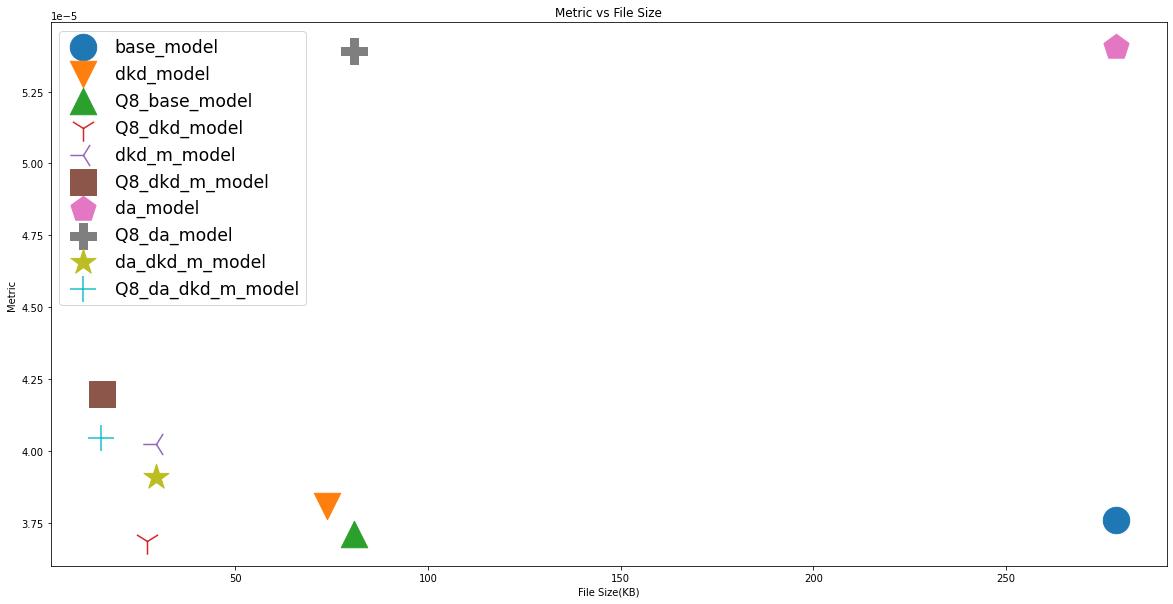

In [185]:
#metric-memory
mrs = ['o', 'v', '^', '1', '3', 's', 'p', 'P', '*', '+']
plt.figure(figsize=(20, 10))
for i, m in enumerate(df.index.values):
    plt.scatter(df.iloc[i]['file_sz'], df.iloc[i]['metric'], marker=mrs[i], label=m, s=700)
plt.legend(fontsize='xx-large')
plt.xlabel('File Size(KB)')
plt.ylabel('Metric')
plt.title('Metric vs File Size')

Text(0.5, 1.0, 'Metric vs Model Size')

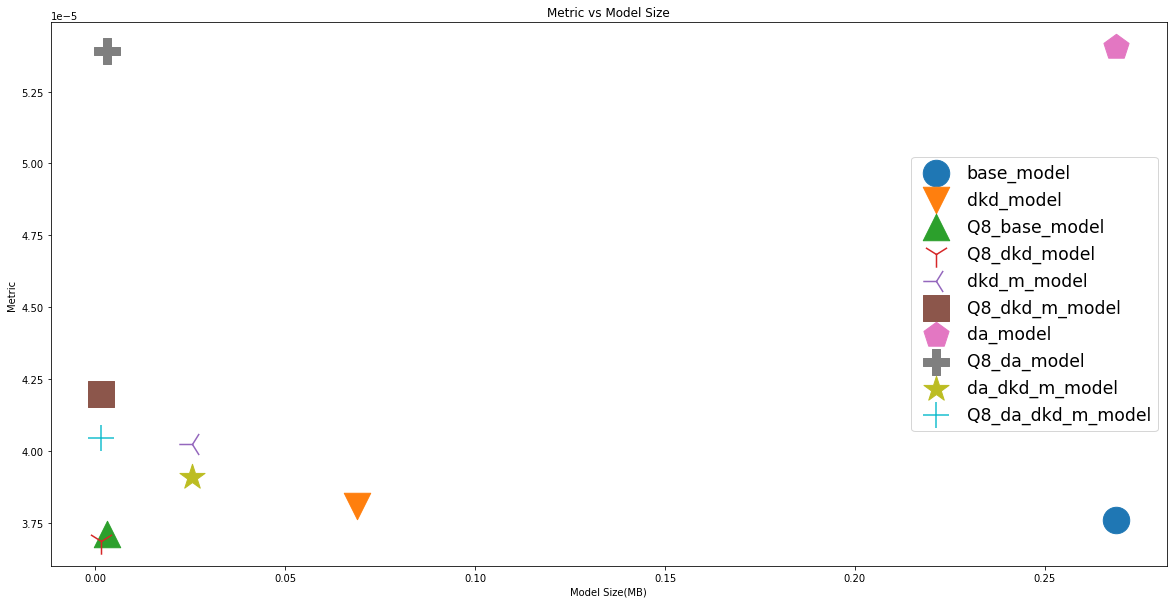

In [186]:
#metric-memory
mrs = ['o', 'v', '^', '1', '3', 's', 'p', 'P', '*', '+']
plt.figure(figsize=(20, 10))
for i, m in enumerate(df.index.values):
    plt.scatter(df.iloc[i]['model_sz'], df.iloc[i]['metric'], marker=mrs[i], label=m, s=700)
plt.legend(fontsize='xx-large')
plt.xlabel('Model Size(MB)')
plt.ylabel('Metric')
plt.title('Metric vs Model Size')

Text(0.5, 1.0, 'Metric vs Macs')

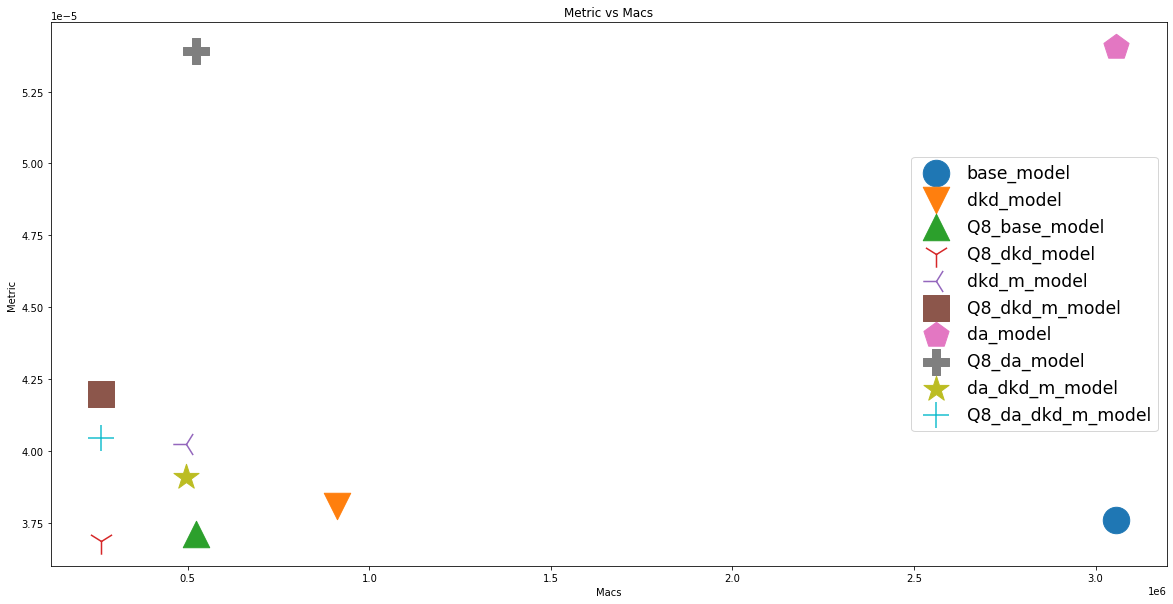

In [187]:
#metric-memory
mrs = ['o', 'v', '^', '1', '3', 's', 'p', 'P', '*', '+']
plt.figure(figsize=(20, 10))
for i, m in enumerate(df.index.values):
    plt.scatter(df.iloc[i]['macs'], df.iloc[i]['metric'], marker=mrs[i], label=m, s=700)
plt.legend(fontsize='xx-large')
plt.xlabel('Macs')
plt.ylabel('Metric')
plt.title('Metric vs Macs')

Тут стоит смотреть на синий плюсик и коричневый квадрат